In [13]:
import pandas as pd


# 加载数据
df = pd.read_csv("data0529/English_news_with_label.csv")

df['label'] = df['label'].str.extract(r'\((\d+)', expand=False).astype(int)
df = df[df['label'] == 1]
df = df[df['content'].str.len() > 300]
df.reindex()

df.to_csv("data0529/sci_news.csv", index=False)

print(len(df))


82948


In [17]:
from tqdm import tqdm
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
import pycountry
import re

# # 下载必要资源（首次运行时需要）
# nltk.download('punkt')
# nltk.download('vader_lexicon')

# 示例国家列表（可根据需要修改）
countries = list({country.name for country in pycountry.countries})

country_nickname = [
    "U.S", "U.K", "America", "England", "US", "UK", "South Korea", "North Korea", "Republic of Korea", "Democratic People's Republic of Korea"
]

# countries = ['United States', 'China']
# country_nickname = ['U.S', 'America', 'US']

def insert_space_after_punctuation(text):
    # 在英文标点 . ? ! 后面加空格（如果没有已有空格）
    return re.sub(r'([.!?])(?=[^\s])', r'\1 ', text)

# 初始化情感分析器
sia = SentimentIntensityAnalyzer()

df = pd.read_csv("data0529/sci_news.csv")

# # 结果存储
results = []

for index, row in tqdm(df.iterrows()):
    content = row['content']
    content = insert_space_after_punctuation(content)
    sentences = sent_tokenize(content)
    total_sentences = len(sentences)
    # print(str(index) + ': '+ str(total_sentences))
    
    # 初始化计数器
    country_stats = {country: {'pos': 0, 'neg': 0} for country in countries}
    
    for sent in sentences:
        sentiment = sia.polarity_scores(sent)
        # 判断积极或消极（compound 是一个综合分数）
        if sentiment['compound'] >= 0.05:
            sentiment_type = 'pos'
            # print(1)
        elif sentiment['compound'] <= -0.05:
            sentiment_type = 'neg'
            # print(2)
        else:
            continue  # 中性情感不计入
        
        for country in countries:
            if country in sent:
                country_stats[country][sentiment_type] += 1
                
        for country in country_nickname:
            if country in sent:
                if country == "U.S" or country == 'US' or country == 'America':
                    country_stats['United States'][sentiment_type] += 1
                # 直接使用pandas的str.contains进行批量处理
                elif country == 'U.K' or country == 'UK' or country == 'England':
                    country_stats['United Kingdom'][sentiment_type] += 1
                elif country == 'South Korea' or country == 'Republic of Korea':
                    country_stats['Korea, Republic of'][sentiment_type] += 1
                elif country == 'North Korea' or country == 'Democratic People\'s Republic of Korea' :
                    country_stats["Korea, Democratic People's Republic of"][sentiment_type] += 1

    # 归一化：每个国家的情感统计 ÷ 总句子数
    result_row = {}
    for country in countries:
        result_row[f'{country}_Pos'] = (country_stats[country]['pos'] / total_sentences) if total_sentences else 0
        # print(result_row[f'{country}_Pos'], country_stats[country]['pos'], total_sentences)
        result_row[f'{country}_Neg'] = (country_stats[country]['neg'] / total_sentences) if total_sentences else 0
    results.append(result_row)

# 合并回原始数据
sentiment_df = pd.DataFrame(results)
final_df = pd.concat([df, sentiment_df], axis=1)

# 保存结果
final_df.to_csv('data0529/sentence_sentiment.csv', index=False)

82948it [04:29, 307.74it/s]


In [ ]:
import pandas as pd


df = pd.read_csv('data0529/sentence_sentiment.csv')
# 确保 date 列为 datetime 类型
df['date'] = pd.to_datetime(df['date'])

# 提取年月作为月份列
df['month'] = df['date'].dt.to_period('M').astype(str)

# 国家列表
# countries = ['China', 'United States']

# 创建空列表收集转换后的数据
panel_data = []

# 遍历每个国家，构造长格式行
for country in countries:
    temp = df[['month', f'{country}_Pos', f'{country}_Neg']].copy()
    temp['country'] = country
    temp.rename(columns={
        f'{country}_Pos': 'Pos',
        f'{country}_Neg': 'Neg'
    }, inplace=True)
    panel_data.append(temp)

# 合并所有国家数据
long_df = pd.concat(panel_data, ignore_index=True)

# 按月和国家分组，取平均
panel_monthly = long_df.groupby(['month', 'country'], as_index=False).mean()

panel_monthly.to_csv('data0529/science_news_sentiment_panel_monthly.csv', index=False)

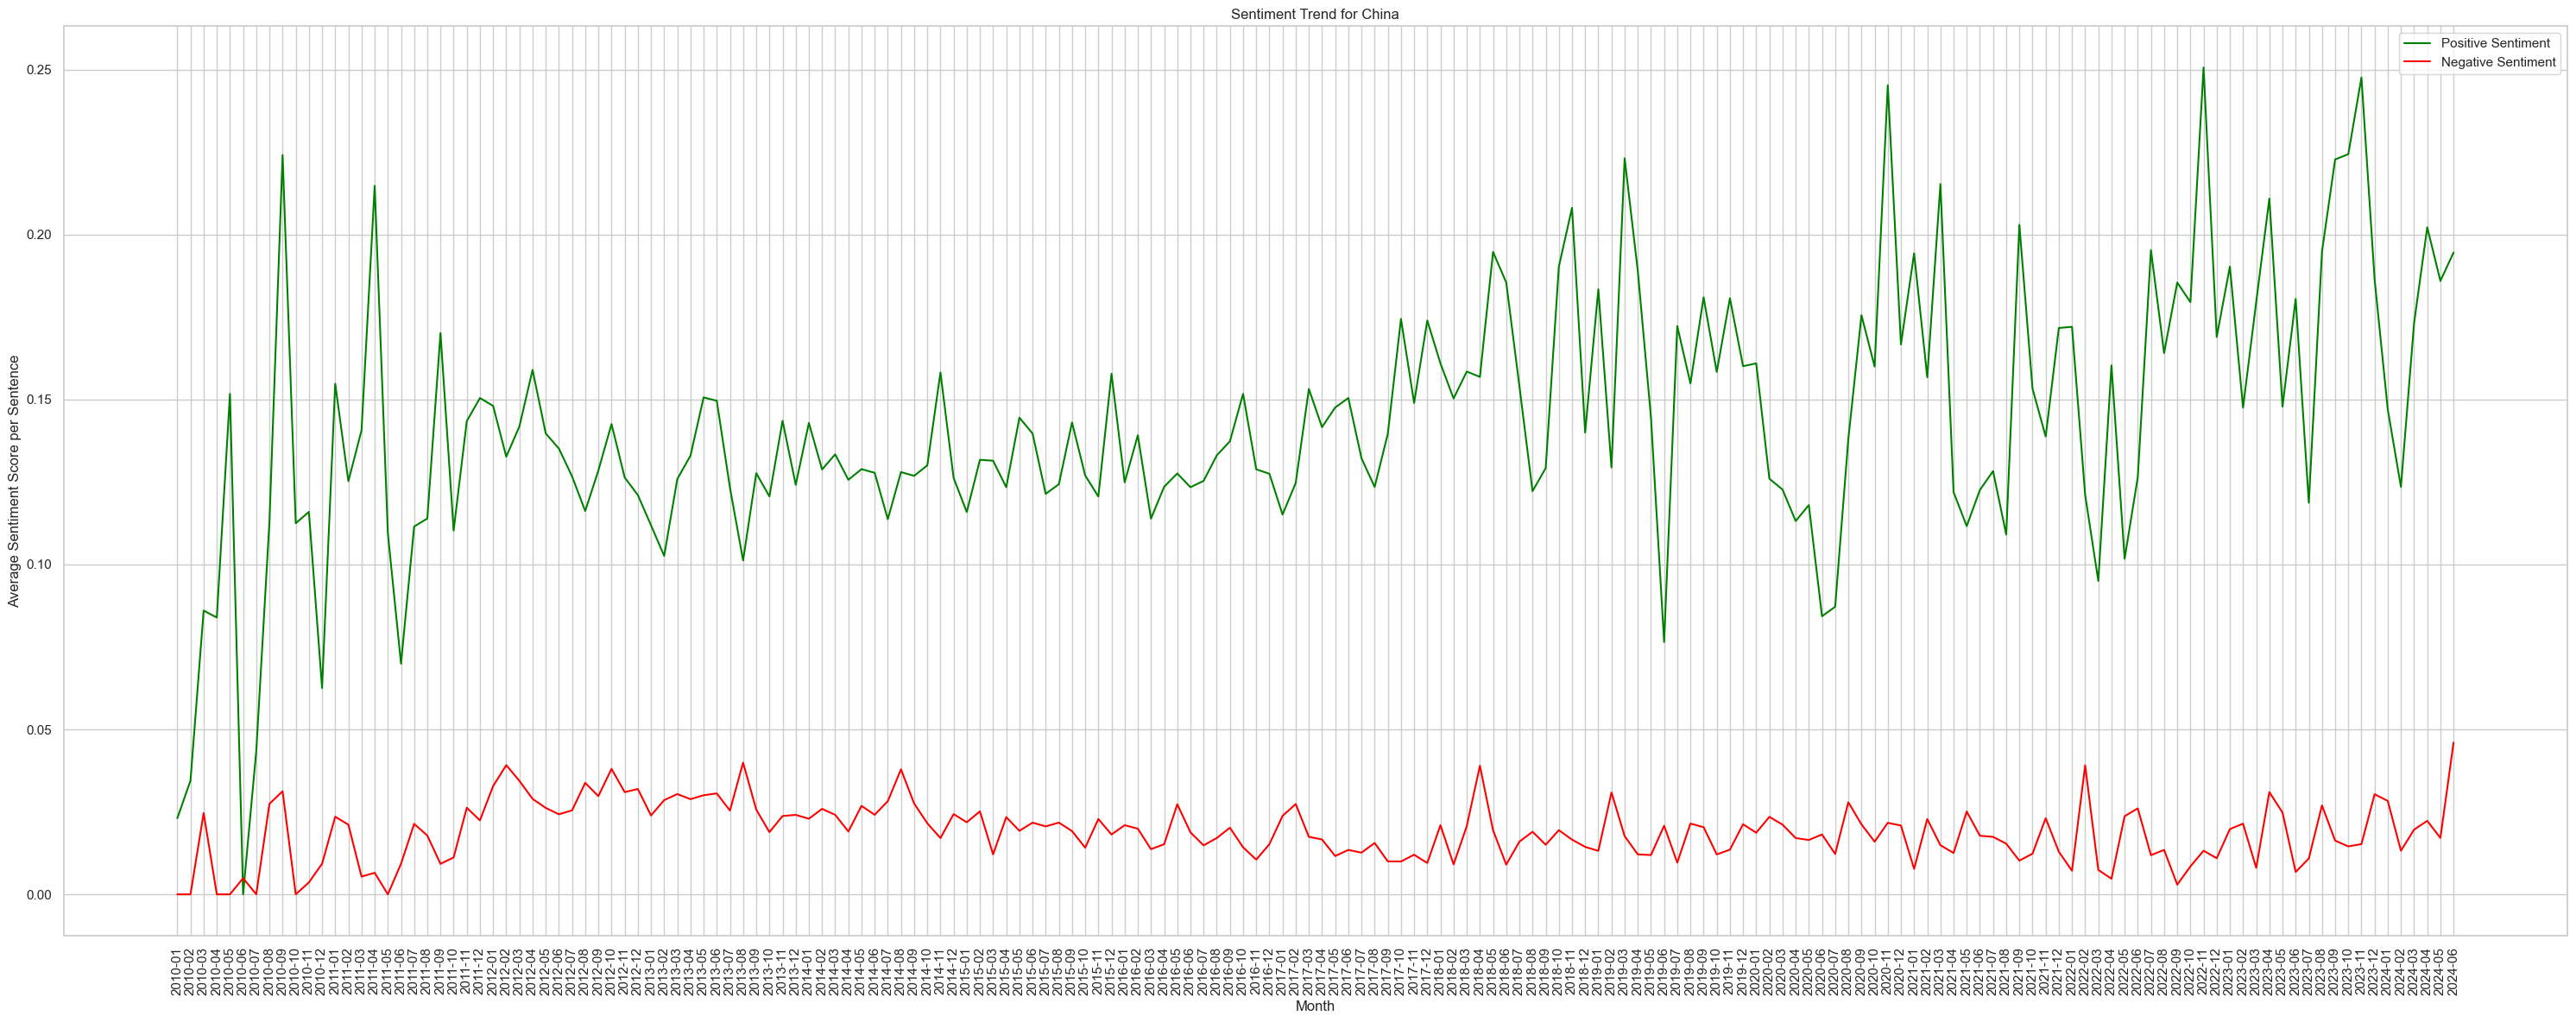

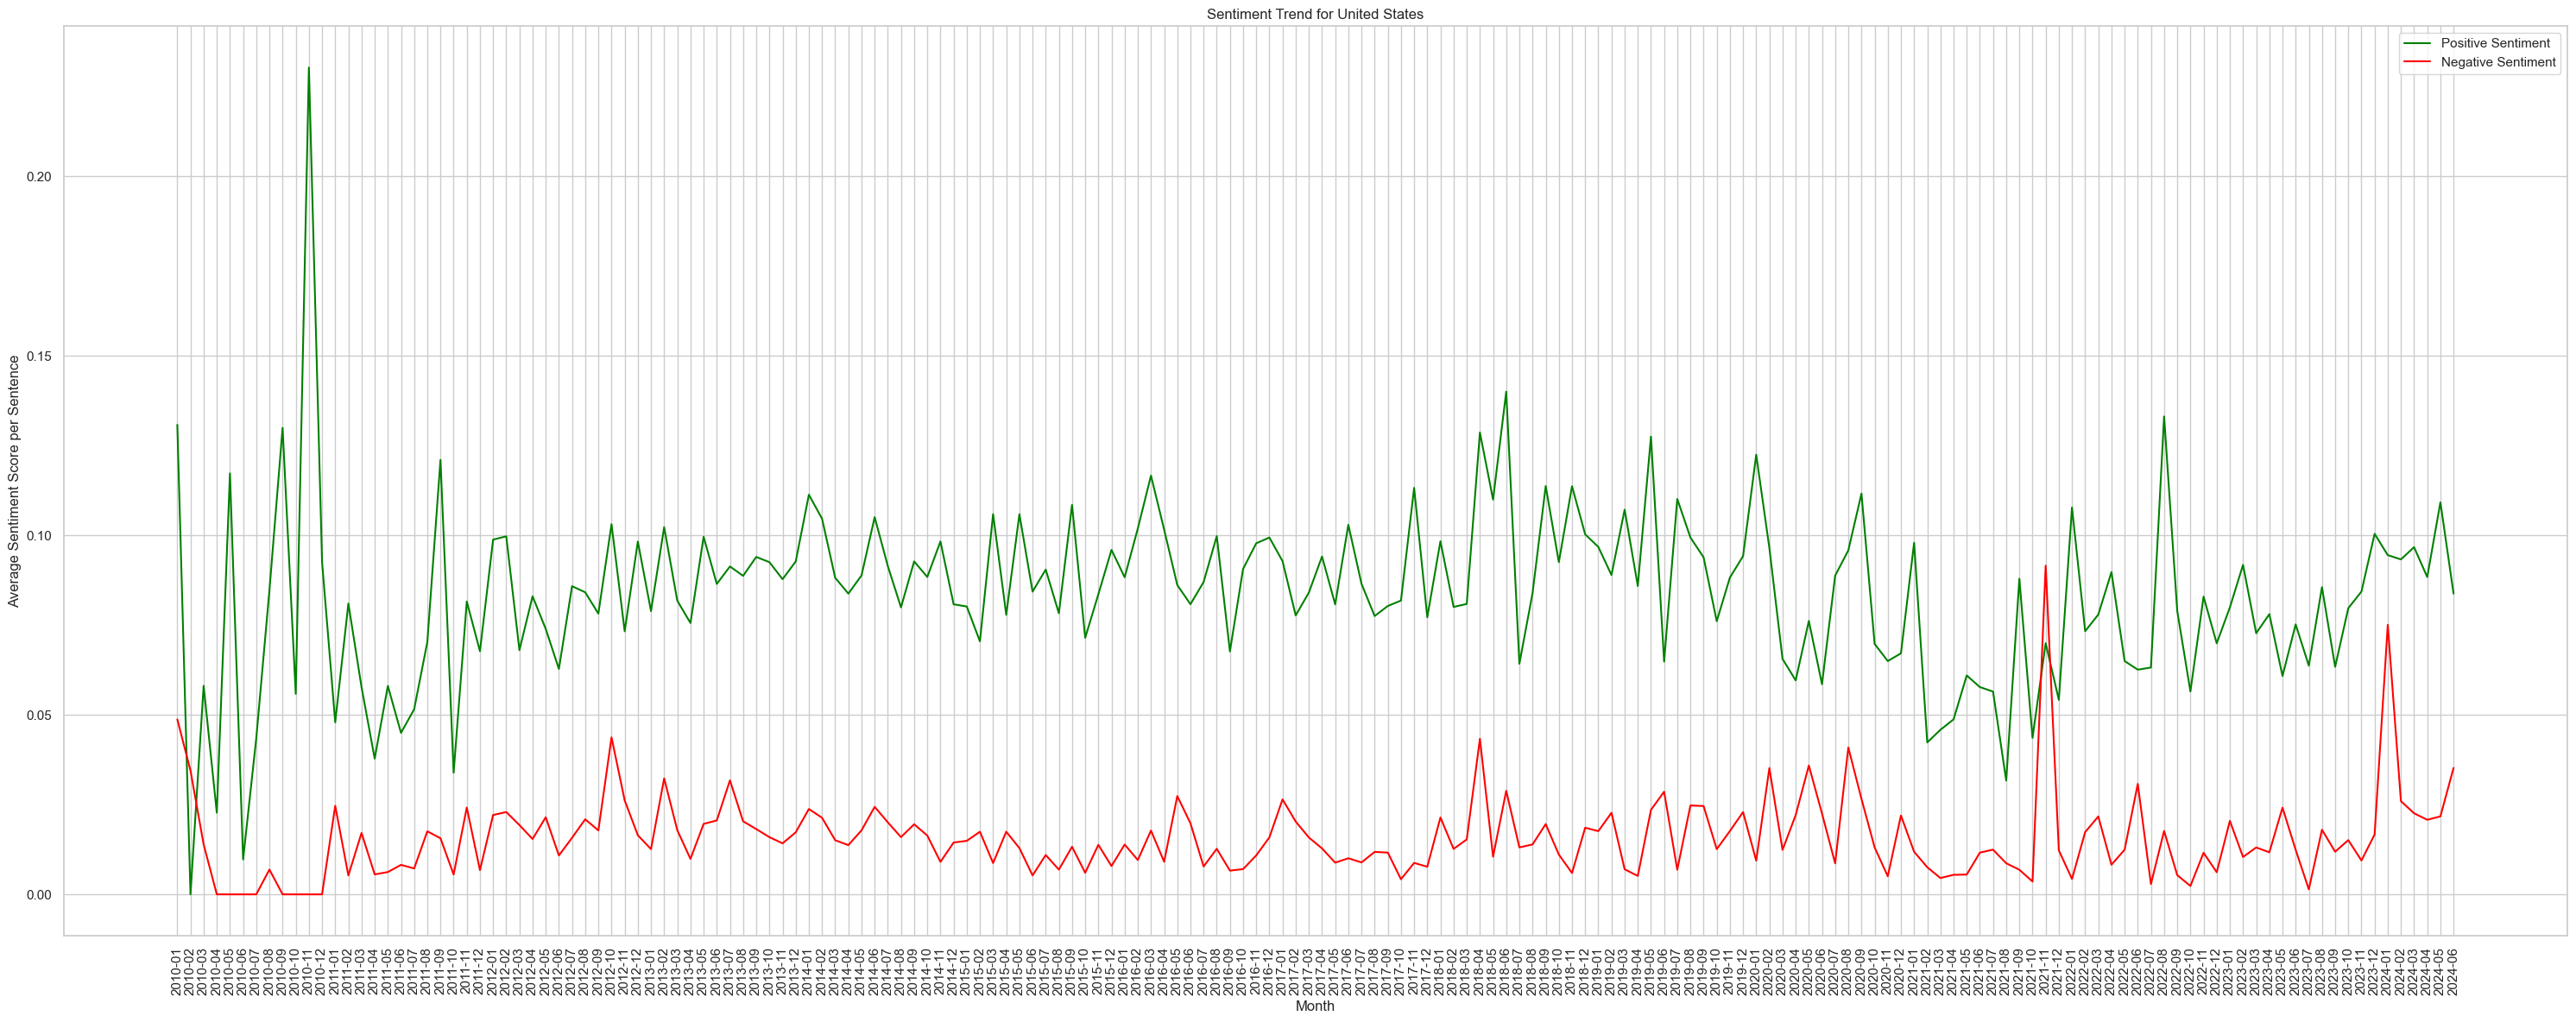

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置图形风格
sns.set(style='whitegrid')

# 假设你已有 panel_monthly，格式如下：
# columns: ['month', 'country', 'Pos', 'Neg']

panel_monthly = pd.read_csv('data0529/science_news_sentiment_panel_monthly.csv')

# 确保按时间顺序排序
panel_monthly = panel_monthly.sort_values(by='month')

panel_monthly = panel_monthly[panel_monthly['month'] >= '2010']

# 遍历国家绘图
for country in panel_monthly['country'].unique():
    data = panel_monthly[panel_monthly['country'] == country]

    plt.figure(figsize=(30, 12))
    
    # 折线图：Pos 情感
    plt.plot(data['month'], data['Pos'], label='Positive Sentiment', color='green')
    plt.plot(data['month'], data['Neg'], label='Negative Sentiment', color='red')

    plt.title(f'Sentiment Trend for {country}')
    plt.xlabel('Month')
    plt.ylabel('Average Sentiment Score per Sentence')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'data0529/figures/{country}_sentiment_trend.png')
    plt.show()


In [7]:
# 提取年份列
panel_monthly['year'] = panel_monthly['month'].str[:4]

# 按国家和年份分组，取平均
panel_yearly = panel_monthly.groupby(['year', 'country'], as_index=False)[['Pos', 'Neg']].mean()
panel_yearly = panel_yearly[panel_yearly['year'] >= '2010']


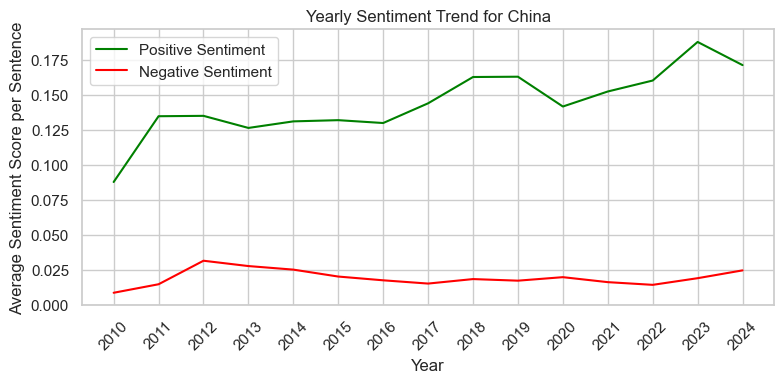

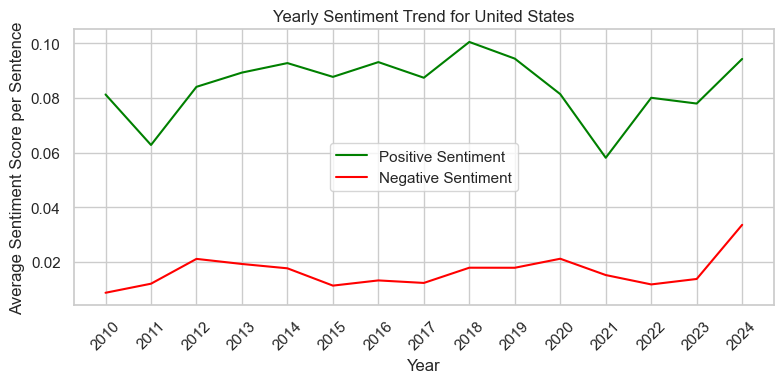

In [9]:
# 遍历国家绘图
for country in panel_yearly['country'].unique():
    data = panel_yearly[panel_yearly['country'] == country]

    plt.figure(figsize=(8, 4))
    plt.plot(data['year'], data['Pos'], label='Positive Sentiment', color='green')
    plt.plot(data['year'], data['Neg'], label='Negative Sentiment', color='red')

    plt.title(f'Yearly Sentiment Trend for {country}')
    plt.xlabel('Year')
    plt.ylabel('Average Sentiment Score per Sentence')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figure/{country}_sentiment_trend_yearly.png')
    plt.show()


In [22]:
from tqdm import tqdm
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
import pycountry
import re

# # 下载必要资源（首次运行时需要）
# nltk.download('punkt')
# nltk.download('vader_lexicon')

# 示例国家列表（可根据需要修改）
countries = list({country.name for country in pycountry.countries})

country_nickname = [
    "U.S", "U.K", "America", "England", "US", "UK", "South Korea", "North Korea", "Republic of Korea", "Democratic People's Republic of Korea"
]

# countries = ['United States', 'China']
# country_nickname = ['U.S', 'America', 'US']

def insert_space_after_punctuation(text):
    # 在英文标点 . ? ! 后面加空格（如果没有已有空格）
    return re.sub(r'([.!?])(?=[^\s])', r'\1 ', text)

# 初始化情感分析器
sia = SentimentIntensityAnalyzer()

df = pd.read_csv("data0529/sci_news.csv")

# # 结果存储
results = []

for index, row in tqdm(df.iterrows()):
    content = row['content']
    content = insert_space_after_punctuation(content)
    sentences = sent_tokenize(content)
    total_sentences = len(sentences)
    # print(str(index) + ': '+ str(total_sentences))
    
    # 初始化计数器
    country_stats = {}
    country_stats['United States'] = {'pos': 0, 'neg': 0}
    country_stats['others'] = {'pos': 0, 'neg': 0}
    
    
    for sent in sentences:
        sentiment = sia.polarity_scores(sent)
        # 判断积极或消极（compound 是一个综合分数）
        if sentiment['compound'] >= 0.05:
            sentiment_type = 'pos'
            # print(1)
        elif sentiment['compound'] <= -0.05:
            sentiment_type = 'neg'
            # print(2)
        else:
            continue  # 中性情感不计入
        
        for country in countries:
            if country in sent:
                if country == "United States":
                    country_stats[country][sentiment_type] += 1
                elif country != "China":
                    country_stats['others'][sentiment_type] += 1
                
        for country in country_nickname:
            if country in sent:
                if country == "U.S" or country == 'US' or country == 'America':
                    country_stats['United States'][sentiment_type] += 1
                else:
                    country_stats['others'][sentiment_type] += 1

    # 归一化：每个国家的情感统计 ÷ 总句子数
    result_row = {}
    for country in ['United States', 'others']:
        result_row[f'{country}_Pos'] = (country_stats[country]['pos'] / total_sentences) if total_sentences else 0
        # print(result_row[f'{country}_Pos'], country_stats[country]['pos'], total_sentences)
        result_row[f'{country}_Neg'] = (country_stats[country]['neg'] / total_sentences) if total_sentences else 0
    results.append(result_row)

# 合并回原始数据
sentiment_df = pd.DataFrame(results)
final_df = pd.concat([df, sentiment_df], axis=1)
# 保存结果
final_df.to_csv('data0529/sentence_sentiment_US&others.csv', index=False)

82948it [03:52, 356.64it/s]


In [26]:
df = pd.read_csv('data0529/sentence_sentiment_US&others.csv')

df['date'] = pd.to_datetime(df['date'])

# 提取年月作为月份列
df['year'] = df['date'].dt.to_period('Y').astype(str)

# 国家列表
# countries = ['China', 'United States']

# 创建空列表收集转换后的数据
panel_data = []

# 遍历每个国家，构造长格式行
df = df[['year', 'United States_Pos', 'United States_Neg', 'others_Pos', 'others_Neg']]

ts = df.groupby('year', as_index=False).mean()


ts.to_csv('data0529/science_news_sentiment_panel_yearly_US&others.csv', index=False)

In [ ]:
import pandas as pd

df1 = pd.read_csv('data0529/science_news_sentiment_ts_monthly_US&others.csv')
df2 = pd.read_csv('data0311/OLS_0523.csv')

df1['month'] = pd.to_datetime(df1['month'])
df2['month'] = pd.to_datetime(df2['month'])

df1 = df1.merge(df2, on='month', how='right')

df1.to_csv('data0529/OLS_0529_monthly.csv', index=False)

In [ ]:
import pandas as pd

# 读取数据
df = pd.read_csv('data0311/OLS_0523.csv')

# 将 'month' 转换为日期格式
df['month'] = pd.to_datetime(df['month'])

# 创建季度列
df['quarter'] = df['month'].dt.to_period('Q')

# 求平均的列
avg_cols = [
    'Analytic_Ratio', 'Clout_Ratio', 'Authentic_Ratio',
    'IMPEXP_growth', 'IMPEXP_posgrowth', 'IMPEXP_neggrowth',
    'EXP_growth', 'EXP_posgrowth', 'EXP_neggrowth',
    'IMP_growth', 'IMP_posgrowth', 'IMP_neggrowth',
    'IXP_EXP_balance', 'GPRH', 'US_MPU', 'UCT',
    'EPUMONETARY', 'EPUSOVDEBT', 'GEPUCURRENT', 'EPUTRADE', 'CLI',
    'Threat_Ratio',
    'Chinese tariffs on ROW exports', 'Chinese tariffs on US exports',
    'US tariffs on Chinese exports', 'US tariffs on ROW exports'
]

# 求和的列
sum_cols = ['IMP_EXP', 'EXP', 'IMP', 'changes']

# 按季度聚合
quarterly = df.groupby('quarter')[avg_cols].mean().join(
    df.groupby('quarter')[sum_cols].sum()
).reset_index()
quarterly['quarter'] = quarterly['quarter'].astype(str)
df3 = pd.read_csv('data0529/science_news_sentiment_ts_quarterly_US&others.csv')

df3 = df3.rename(columns={'month': 'quarter'})
# df3['quarter'] = pd.to_datetime(df3['quarter'])

quarterly = quarterly.merge(df3, on='quarter', how='left')

# 可选：转换回季度字符串如 "2020Q1"


# 保存结果
quarterly.to_csv('data0529/OLS_0529_quarterly.csv', index=False)

print("✅ 按季度聚合完成，已保存为 quarterly_data.csv")


✅ 按季度聚合完成，已保存为 quarterly_data.csv


In [6]:
import pandas as pd

# 读取数据
df = pd.read_csv('data0311/OLS_0523.csv')

# 将 'month' 转换为日期格式
df['month'] = pd.to_datetime(df['month'])

# 创建季度列
df['year'] = df['month'].dt.to_period('Y')

# 求平均的列
avg_cols = [
    'Analytic_Ratio', 'Clout_Ratio', 'Authentic_Ratio',
    'IMPEXP_growth', 'IMPEXP_posgrowth', 'IMPEXP_neggrowth',
    'EXP_growth', 'EXP_posgrowth', 'EXP_neggrowth',
    'IMP_growth', 'IMP_posgrowth', 'IMP_neggrowth',
    'IXP_EXP_balance', 'GPRH', 'US_MPU', 'UCT',
    'EPUMONETARY', 'EPUSOVDEBT', 'GEPUCURRENT', 'EPUTRADE', 'CLI',
    'Threat_Ratio',
    'Chinese tariffs on ROW exports', 'Chinese tariffs on US exports',
    'US tariffs on Chinese exports', 'US tariffs on ROW exports'
]

# 求和的列
sum_cols = ['IMP_EXP', 'EXP', 'IMP', 'changes']

# 按季度聚合
yearly = df.groupby('year')[avg_cols].mean().join(
    df.groupby('year')[sum_cols].sum()
).reset_index()
yearly['year'] = yearly['year'].astype(str)
df3 = pd.read_csv('data0529/science_news_sentiment_ts_yearly_US&others.csv')

df3 = df3.rename(columns={'month': 'year'})
df3['year'] = df3['year'].astype(str)
# df3['quarter'] = pd.to_datetime(df3['quarter'])

yearly = yearly.merge(df3, on='year', how='left')

# 可选：转换回季度字符串如 "2020Q1"


# 保存结果
yearly.to_csv('data0529/OLS_0529_yearly.csv', index=False)

print("✅ 按季度聚合完成，已保存为 yearly_data.csv")


✅ 按季度聚合完成，已保存为 yearly_data.csv
